##Amir mahdi Farzane
##810100194

##CA5 - CNN for image classification

In [1]:
!pip install torchinfo

In [2]:
import random
import os
import glob
import time
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.optim.lr_scheduler as lr_scheduler

from torch import nn
from torch.utils.data import (Dataset, DataLoader)

from torchvision import transforms
from torchinfo import summary

from PIL import Image
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
# from scikitplot.metrics import plot_roc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score,
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)

In [3]:
import os
from google.colab import drive

In [4]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/CA5-CNN')

Mounted at /content/drive


In [53]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 4
    EPOCHS = 15
    BATCH_SIZE =  16
    LR = 0.001
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 512
    WIDTH = 512
    CHANNELS = 3
    IMAGE_SIZE = (512, 512, 3)

# Mute warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [6]:
%%time
train_images = glob.glob(f"./AI-CA5-Dataset/**/*.jpg")

CPU times: user 26.1 ms, sys: 1.27 ms, total: 27.3 ms
Wall time: 4.26 s


In [7]:
def generate_labels(image_paths):
    return [(_.split('/')[-2:][0]).replace('-', '_') for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })

    # Return df
    return df
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
# test_df = build_df(test_images, generate_labels(test_images))


In [8]:
def _load(image_path, as_tensor=True):
    # Read and decode an image file to a uint8 tensor
    image = Image.open(image_path)

    if as_tensor:
        converter = transforms.Compose([
            transforms.ToTensor(),
            transforms.Grayscale()
        ])
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)

    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)

    plt.title(f'Label: {label}', fontsize=16)
    return

In [9]:
def sample_each_class(group):
    return group.sample(1)

# Use groupby and apply to get a sample of each class
samples = train_df.groupby('label', group_keys=False).apply(sample_each_class)

In [10]:
type(samples)


pandas.core.frame.DataFrame

In [11]:
s = (list(samples.get('image_path')))
print(s[0])

./AI-CA5-Dataset/glioma/Te-gl_0028.jpg


In [12]:
 l = list(samples.get('label'))

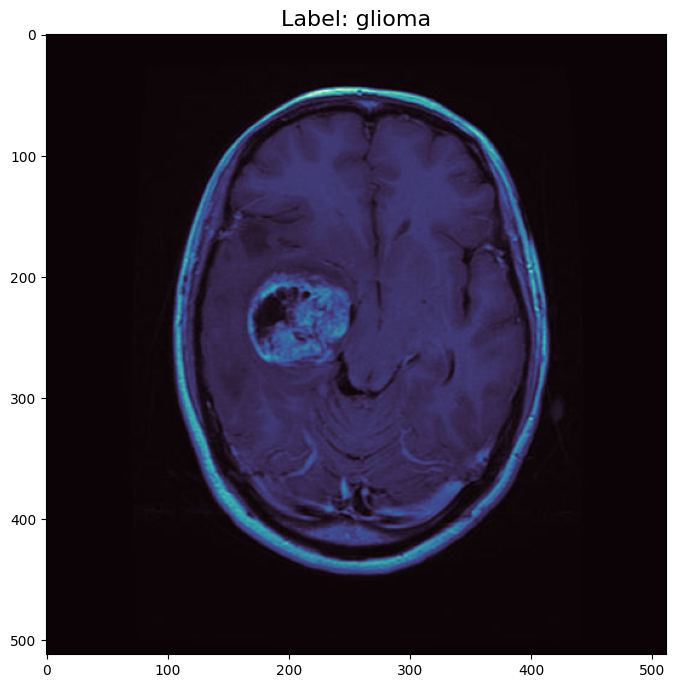

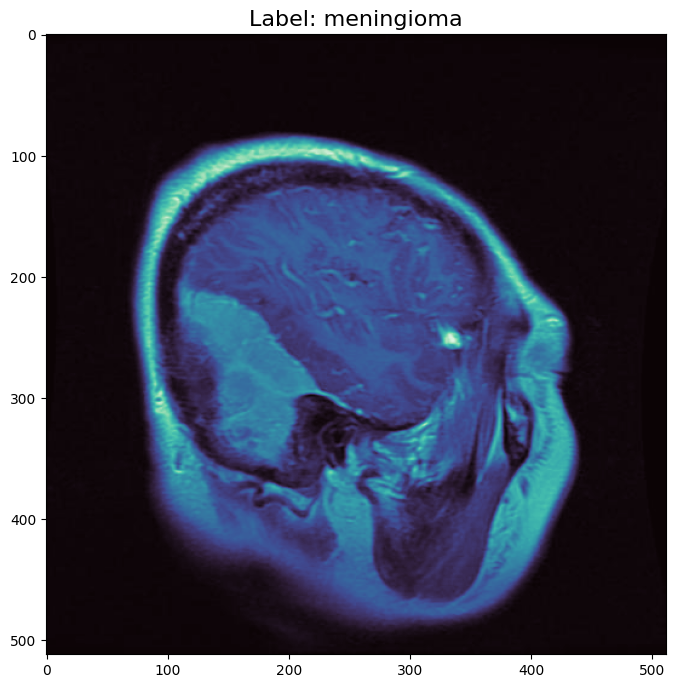

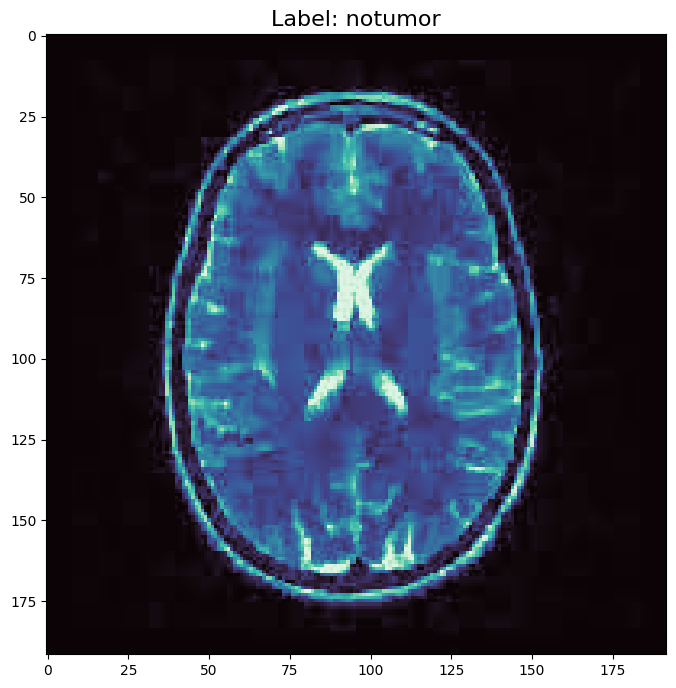

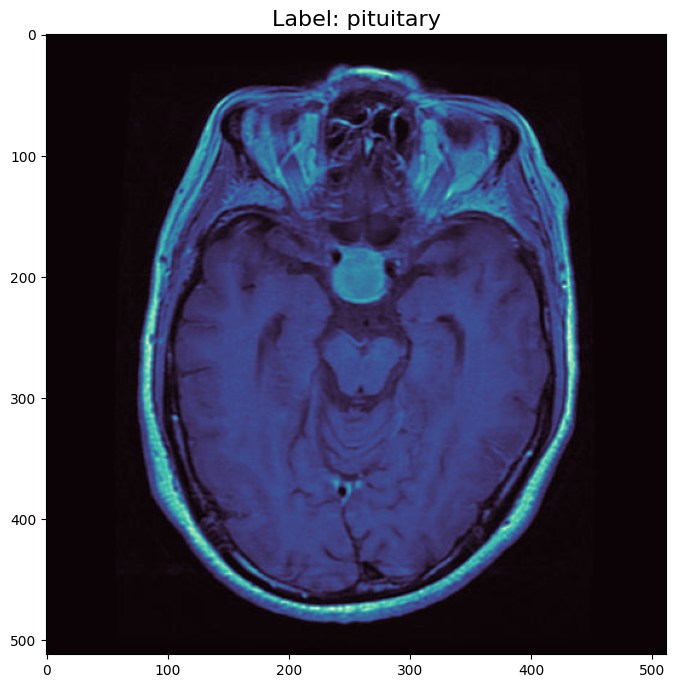

In [13]:
for i in range(4):
    sample_image, sample_label = _load(s[i]), l[i]
    view_sample(
    sample_image.permute(1, 2, 0),
    sample_label,
    color_map='mako',
    )

I divide train and test by 0.2 raation and 0.2 ratio for validation and train.

The 80-20 split (80% for training, 20% for testing) is a common practice in machine learning. It provides enough data for training, allowing the model to learn patterns, while the testing set assesses the model's ability to generalize to new, unseen data. This split helps prevent overfitting and provides a reliable estimate of the model's performance on real-world examples.

In [14]:
train_df, test_df = train_test_split(train_df, test_size=0.2)

In [15]:
train_df, val_df = train_test_split(train_df, test_size=0.2)

#Normalization

I did'nt use normalization because we must consider color intensity and by normalization we loss some information about intesity of colors.

As we will see batch normalization didn;t have good impact on result.

In [16]:
label_count = []
classes = ["notumor" , "glioma" , "meningioma" , "pituitary"]
for s in (classes):
    label_count.append(np.sum(train_df.label==s))
    # print('No. of images with',i,'label:',label_count[-1])

In [17]:
label_count

[254, 187, 202, 195]

Text(0.5, 1.0, 'Label Count Distribution in Train Set')

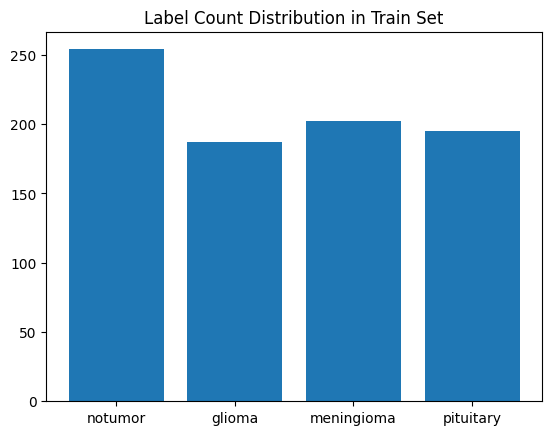

In [18]:
x = np.arange(len(label_count))+1
plt.bar(classes,label_count)
plt.title('Label Count Distribution in Train Set')

In [19]:
label_count = []
classes = ["notumor" , "glioma" , "meningioma" , "pituitary"]
for s in (classes):
    label_count.append(np.sum(val_df.label==s))
    # print('No. of images with',i,'label:',label_count[-1])

Text(0.5, 1.0, 'Label Count Distribution in Train Set')

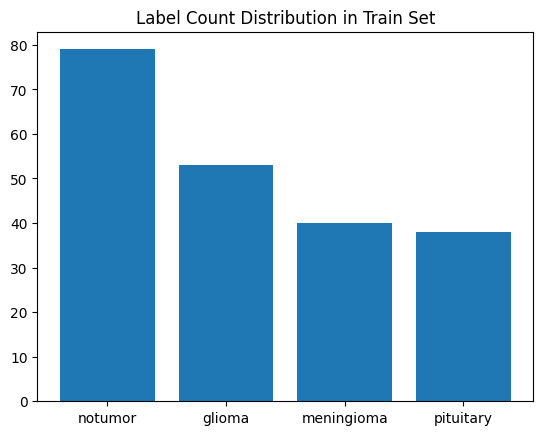

In [20]:
x = np.arange(len(label_count))+1
plt.bar(classes,label_count)
plt.title('Label Count Distribution in Train Set')

In [21]:

train_df.shape, val_df.shape

((838, 2), (210, 2))

In [22]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		838	(63.92%)
validation samples count:	210	(16.02%)
test samples count:		263	(20.06%)
TOTAL:				1311	(100.00%)


In [23]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    # transforms.Normalize(mean, std),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30,),
    transforms.ToTensor()
])

# Only reshape test data
test_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    # transforms.Normalize(mean, std),
    transforms.ToTensor()
])

In [24]:
# Select random sample from train_df
idx = random.sample(train_df.index.to_list(), 1)[0]

# Load the random sample and label
aug_image = _load(train_df.image_path[idx], as_tensor=False)

In [25]:
class BrainTumorMRIDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()

        self.paths = df['image_path'].to_list()
        self.labels = df['label'].to_list()
        self.transform = transform

        self.classes = sorted(list(df['label'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}

    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')

    def __len__(self) -> int:
        return self.paths.__len__()

    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

In [26]:
# Build train dataset
train_ds = BrainTumorMRIDataset(train_df, transform=train_transforms)

# Build validation dataset
val_ds = BrainTumorMRIDataset(val_df, transform=test_transforms)

# Build test dataset
test_ds = BrainTumorMRIDataset(test_df, transform=test_transforms)

In [27]:
train_loader = DataLoader(
    dataset=train_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)

# Build validation dataloader
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

# Build test dataloader
test_loader = DataLoader(
    dataset=test_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

#pooling layer


Pooling layers in CNNs offer advantages such as spatial hierarchies, translation invariance, reduced parameters, computation efficiency, increased receptive field, and feature generalization. They help down-sample spatial dimensions, making models computationally efficient, less sensitive to small variations, and capable of capturing larger patterns in the data.

I use two pooling layer with ptride 2 and kernel size2 because of mentioned reasones.

#kernel size
Firstly, it provides a smaller receptive field, allowing the network to capture local features and intricate patterns in images. Secondly, it is parameter-efficient, requiring fewer parameters compared to larger kernels, leading to faster training and reduced computational requirements. Thirdly, the use of multiple layers with 3x3 convolutions facilitates hierarchical feature learning, enabling the network to understand complex patterns in a structured manner. Additionally, 3x3 convolutions preserve translation invariance, contributing to better generalization.

But it is possible larger kernel bu maybe loss more information and shorter can;t extract enough data as much as we need.

#stride

I used a stride of 2 in Convolutional Neural Networks (CNNs) is commonly employed to reduce the spatial dimensions of the feature maps. This downsampling, achieved by skipping every alternate pixel during convolution, helps increase computational efficiency and reduces the spatial resolution of the feature maps. Additionally, it can contribute to capturing more abstract and high-level features by focusing on larger receptive fields. Stride 2 is often used in pooling layers or specific convolutional layers to efficiently downsample the spatial dimensions of the input, aiding in faster computation and improved hierarchical feature learning.

#padding

I used padding to prevent sudden waste feautures .And is used to maintain spatial dimensions during convolution and prevent a reduction in feature map size. It helps ensure that convolutional operations can be applied to the border pixels of the input, preserving important information at the edges.

#number of kernels
Firstly i used 16 kernel and then 32 because images are 512*512*3 and is possible to get enough information.

And i used two fully connected layers

#number of nodes in  fully connected layer
For prevent sudden change from a lot of nodes to just 4 nodes and 512 middle nodes used to get better perfomance from features.

#activation

**Relu**
f(x)=max(0,x)

Pros: Simple and computationally efficient, helps mitigate the vanishing gradient problem, promotes sparsity.
Cons: Not suitable for all types of data, may suffer from "dying ReLU" problem if a large gradient flows through and updates weights in a way that the neuron will always output zero.

 I used in middle layers

 **Sigmoid**

 f(x) = 1 / (1 + e^(-x))

 Pros: Outputs values between 0 and 1, which can be interpreted as probabilities, suitable for binary classification problems.
Cons: Prone to vanishing gradient problem, outputs are not zero-centered, meaning the updates in weight during backpropagation can be too extreme.

**softmax**

Pros:

Converts raw scores into probabilities, making it suitable for multi-class classification.
Facilitates clear decision-making by emphasizing the most probable class.
Cons:

Sensitive to outliers and large input values.
Can amplify small differences in input values, potentially leading to numerical instability.

Is for multiclass classification tasks like this task i used in last layer and relu for middle layers.


In [28]:
class ComplexCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate =  0.4):
        super(ComplexCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 128 * 128, 512)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Input shape: [32, 3, 512, 512]
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [29]:
model = ComplexCNN()

# Print the model architecture
print(model)

ComplexCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=524288, out_features=512, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


In [30]:
summary(
    model=model,
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ComplexCNN (ComplexCNN)                  [16, 3, 512, 512]    [16, 4]              96                   True
├─Conv2d (conv1)                         [16, 3, 512, 512]    [16, 16, 512, 512]   448                  True
├─ReLU (relu1)                           [16, 16, 512, 512]   [16, 16, 512, 512]   --                   --
├─MaxPool2d (pool1)                      [16, 16, 512, 512]   [16, 16, 256, 256]   --                   --
├─Conv2d (conv2)                         [16, 16, 256, 256]   [16, 32, 256, 256]   4,640                True
├─ReLU (relu2)                           [16, 32, 256, 256]   [16, 32, 256, 256]   --                   --
├─MaxPool2d (pool2)                      [16, 32, 256, 256]   [16, 32, 128, 128]   --                   --
├─Linear (fc1)                           [16, 524288]         [16, 512]            268,435,968          True
├─ReLU (relu3)        

#Loss function

I used categorical croos-entropy  becaus it is multi class classification.

some types are as follows:

Mean Squared Error (MSE):

Used for regression tasks.
Measures the average squared difference between predicted and actual values.
Binary Cross-Entropy Loss:

Commonly used for binary classification tasks.
Measures the cross-entropy between predicted probabilities and actual binary labels.

Categorical Cross-Entropy Loss:
Applied in multi-class classification tasks.
Measures the cross-entropy between predicted class probabilities and one-hot encoded class labels.

In [31]:
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

**Stochastic Gradient Descent (SGD)**:

Update Rule: Updates parameters by moving against the gradient of the loss function.

Learning Rate: Requires manual tuning of a global learning rate.

Adaptability: Less adaptive to varying learning rates and may need momentum for faster convergence.

**Adam (Adaptive Moment Estimation):**

Update Rule: Combines momentum and RMSprop, adapting learning rates for each parameter.

Learning Rate: Adapts learning rates individually, reducing sensitivity to hyperparameter choices.

Adaptability: More adaptive and often converges faster, making it a popular default choice.
Comparison:

I used adam becaus is generally more adaptive, requires less manual tuning, and often converges faster.

In [32]:


# Define Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG.LR
)

In [33]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:

    # Set model into training mode
    model.train()

    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0

    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)

        # Feed-forward and compute metrics
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()

        # Update Model Gradients
        optimizer.step()

        # Compute Batch Metrics
        predicted_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)

    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [34]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:

    # Set model into eval mode
    model.eval()

    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0

    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()

            # Compute Batch Metrics
            predicted_class = torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)

    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)

    return eval_loss, eval_acc

In [35]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:

    # Initialize training session
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []
    }

    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model,
            train_dataloader,
            optimizer,
            loss_fn,
            device
        )

        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model,
            eval_dataloader,
            loss_fn,
            device
        )

        # Log Epoch Metrics
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')

        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)

    # Return Session Metrics
    return session

In [36]:
torch.cuda.empty_cache()

In [ ]:
# Train the model
print('Training EfficientNet Model')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

efficientnet_session_config = {
    'model'               : model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}

efficientnet_session_history = train(**efficientnet_session_config)

In [38]:
def predict(
    model:nn.Module,
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:

    # Set model into eval mode
    model.eval()

    predictions = []

    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)

            # Compute Batch Metrics
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()

            # Record prediction
            predictions.append(predicted_probs)

    return np.vstack(predictions)

In [39]:
def plot_training_curves(history):

    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['eval_accuaracy'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='eval_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

    sns.despine();

    return

In [ ]:
efficientnet_session_history_df = pd.DataFrame(efficientnet_session_history)

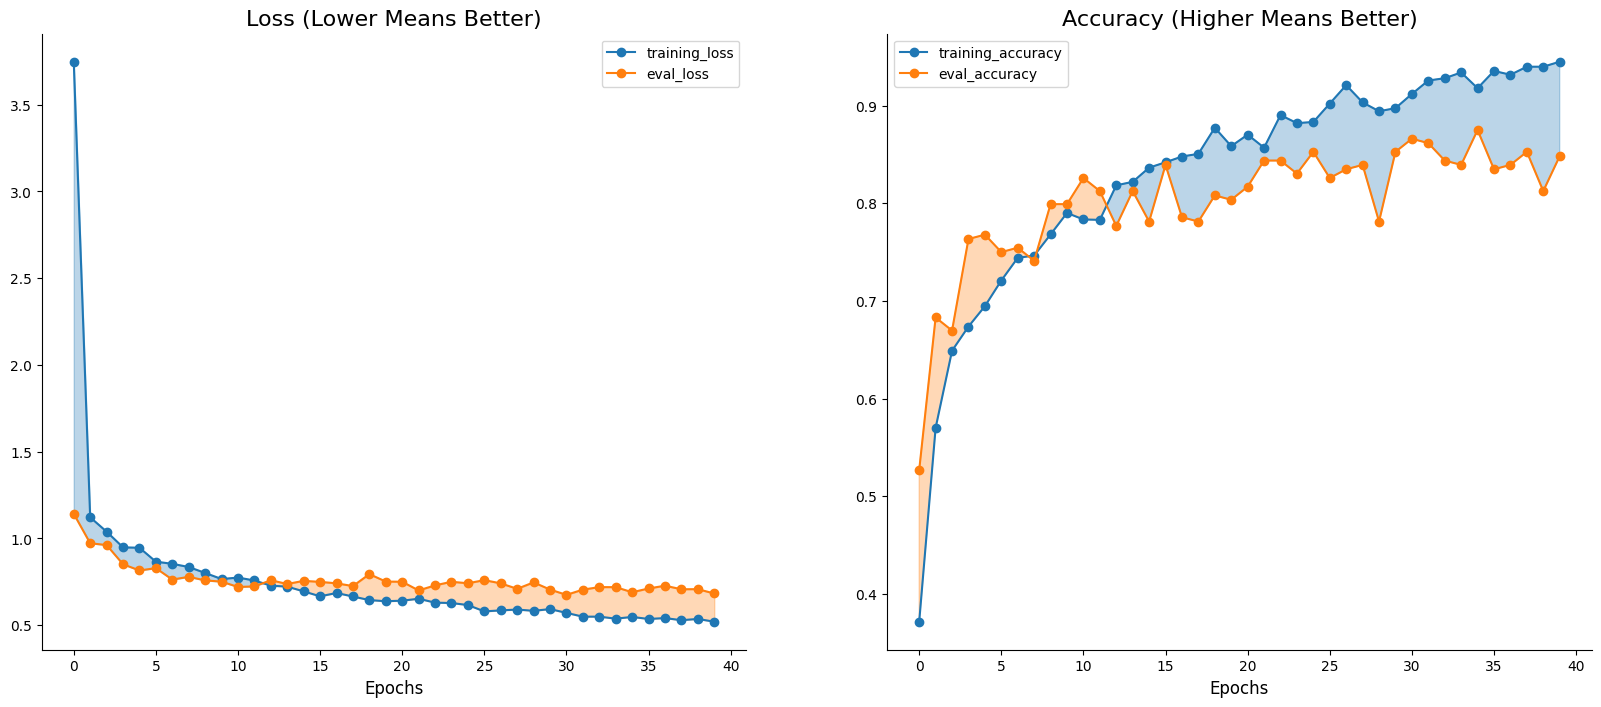

In [41]:
plot_training_curves(efficientnet_session_history_df)

In [42]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

#Dropout
Dropout helps to prevent overfitting because one resaon of overfitting is high number of parameters so by dropout we reduce number of extra parameters.

#Batch normalization

 Improve training stability and accelerate convergence. It normalizes the input of each layer in a mini-batch by subtracting the batch mean and dividing by the batch standard deviation. This helps mitigate issues like internal covariate shift and allows the network to learn more efficiently.

We must use

In [ ]:
vit_test_probs = predict(model, test_loader, CFG.DEVICE)

In [44]:
vit_test_preds = np.argmax(vit_test_probs, axis=1)

In [45]:
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

In [ ]:
efficientnet_session_history_df = pd.DataFrame(efficientnet_session_history)

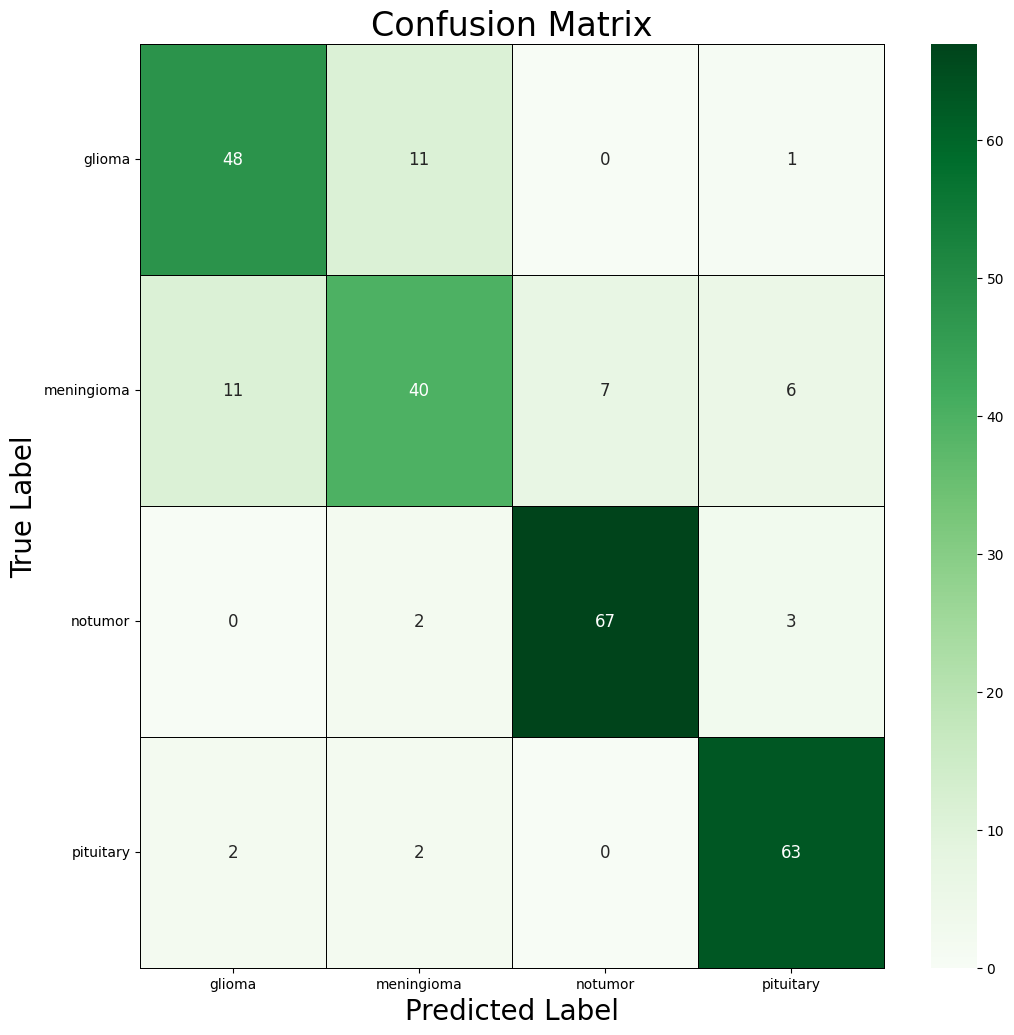

In [55]:
plot_confusion_matrix(
    test_labels,
    vit_test_preds,
    figsize=(12, 12),
    classes=test_ds.classes)

In [48]:
print(
    classification_report(
        test_labels,
        vit_test_preds,
        target_names=test_ds.classes
))

              precision    recall  f1-score   support

      glioma       0.79      0.80      0.79        60
  meningioma       0.73      0.62      0.67        64
     notumor       0.91      0.93      0.92        72
   pituitary       0.86      0.94      0.90        67

    accuracy                           0.83       263
   macro avg       0.82      0.82      0.82       263
weighted avg       0.82      0.83      0.83       263



In [49]:
train_df['label'].value_counts()

notumor       254
meningioma    202
pituitary     195
glioma        187
Name: label, dtype: int64